# Main Objective of the task is to perform a semantic search on the documents and retrieve the relevant documents


In [ ]:
from bs4 import BeautifulSoup
import os 
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import pickle
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Preprocessing step:
1.Extracting text content from the xml files which is present in <post> tag.



In [ ]:
# Fetch the content 
def get_file_content(path,file_names,en):
  """Extracts blog content in <post> tags in xml file """
  file_text = {}
  lang_exception = []
  for file_name in file_names:
    if file_name.strip().split(".")[0] in en:
      posts_list = []
      try:
        with open(path+file_name, "r",encoding='utf-8-sig',errors='ignore') as file_obj:
          contents = file_obj.read()
          soup = BeautifulSoup(contents, 'lxml')
          # Each post is assumed as a chunk and the content is extracted from the post tag.
          for tag in soup.find_all("post"):
            temp = tag.text.replace("\\", "").replace("\t",'').replace("\n",'').replace('urlLink','').lower()
            if detect(temp)== 'en': # Remove non-english documents
              if len(temp.split()) > 10:
                temp = ' '.join([(contractions.fix(word)) for word in temp.split()])
                posts_list.append(temp)
      except IOError:
        print("Error: Input XML files not found ",file_name)
        pass
      except: 
        print('Language detection error',file_name.strip().split(".")[0])
        lang_exception.append(file_name.strip().split(".")[0])
        pass
      file_text[file_name.strip().split(".")[0]] = posts_list
  return file_text,lang_exception

In [ ]:
# Fetch the content from xml files in given directory
path = '/content/blogs/'
files_list = os.listdir(path)
total_content,lang_exception = get_file_content(path,files_list,file_chunk_content.keys())

# 2. Perform following steps on the extracted chunks(posts) from blogs 

*   Sentence tokenization 
*   Removal of punctuation





In [ ]:
# Remove the punctuations from the sentences
def remove_punctuation(content):
  return ' '.join([token for token in content.split() if token.isalpha() == True])

# Method to perform preprocessing task
def preprocess_text(blog_text):
  sentences = nltk.sent_tokenize(blog_text)
  sentences = [remove_punctuation(sentence) for sentence in sentences]
  sentences = ' '.join(sentences)
  return sentences

In [ ]:
# Perform preprocessing on the blog content
def get_preprocessed_content(blog_content)
  preprocessed_blogs = {}
  for index, key in enumerate(list(blog_content.keys())):
    preprocessed_blogs[key] = list(map(preprocess_text,blog_content[key]))
    if index%1000 == 0:
          print('Preprocessing done for ', index)
  return preprocessed_blogs

Preprocessing done for  0
Preprocessing done for  1000
Preprocessing done for  2000
Preprocessing done for  3000
Preprocessing done for  4000
Preprocessing done for  5000
Preprocessing done for  6000
Preprocessing done for  7000
Preprocessing done for  8000
Preprocessing done for  9000
Preprocessing done for  10000
Preprocessing done for  11000
Preprocessing done for  12000
Preprocessing done for  13000
Preprocessing done for  14000
Preprocessing done for  15000
Preprocessing done for  16000
Preprocessing done for  17000
Preprocessing done for  18000
Preprocessing done for  19000


In [ ]:
# Perform pre-processing task
processed_blog_data = get_preprocessed_content(total_content)

In [ ]:
# Store the preprocessed_data in a pickle file
pickle.dump(processed_blog_data,open('all_processed_final_min_sentence_length_dict.pickle','wb'),protocol= pickle.HIGHEST_PROTOCOL)
!cp "/content/all_processed_final_min_sentence_length_dict.pickle" "/content/drive/MyDrive/all_processed_final_min_sentence_length_dict.pickle" 

In [ ]:
processed_blog_data = pickle.load(open('/content/all_processed_final_min_sentence_length_dict.pickle','rb'))

#3. Generate embeddings using Universal Sentence Encoder (USE) for each post (chunk) in the blog

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

class USEModel():
  @staticmethod
  def  get_USE_model():
     # Import the Universal Sentence Encoder's Hub module
    module_url = "https://tfhub.dev/google/universal-sentence-encoder/3"
    model = hub.load(module_url)
    return model

In [ ]:
def generate_blog_embeddings(blog_dict):
  blog_embedding = {}
  model_USE = USEModel.get_USE_model()
  for index, key in enumerate(list(blog_dict.keys())):
    # Storing the embeddings for the blog content
    blog_embedding [key] = [model_USE([post])['outputs'].numpy().reshape(1,-1) for post in blog_dict[key]]
    if index%1000 == 0:
      print('Embeddings generated for ', index)
  return blog_embedding

Embeddings generated for  0
Embeddings generated for  1000
Embeddings generated for  2000
Embeddings generated for  3000
Embeddings generated for  4000
Embeddings generated for  5000
Embeddings generated for  6000
Embeddings generated for  7000
Embeddings generated for  8000
Embeddings generated for  9000
Embeddings generated for  10000
Embeddings generated for  11000
Embeddings generated for  12000
Embeddings generated for  13000
Embeddings generated for  14000
Embeddings generated for  15000
Embeddings generated for  16000
Embeddings generated for  17000


In [ ]:
# Generate embeddings for the preprocessed chunks
blog_embeddings  = generate_blog_embeddings(processed_blog_data)

# save the embeddings for the preprocessed chunks
pickle.dump(blog_embeddings,open('final_embeddings_dict.pickle','wb'),protocol= pickle.HIGHEST_PROTOCOL)
!cp "/content/final_embeddings_dict.pickle" "/content/drive/MyDrive/final_embeddings_dict.pickle" 

#4. Retrieving the sorted results based on relevance score for a given query

In [ ]:
# Retrieving pickle files from drive
!cp '/content/drive/MyDrive/final_embeddings_dict.pickle' '/content/final_embeddings_dict.pickle'
!cp '/content/drive/MyDrive/all_processed_final_min_sentence_length_dict.pickle' '/content/all_processed_final_min_sentence_length_dict.pickle'  


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# Method to calclulate similarity for the given query 
def get_similar_blogs(query,blog_embedding):
  # Generate embedding for the query
  model_USE = USEModel.get_USE_model()
  embed_query = model_USE([query])['outputs'][0].numpy().reshape(1,-1)
  similarity = {}
  for key in blog_embedding.keys():
    post_sim  = []
    for post in blog_embedding[key]:
      post_sim.append(cosine_similarity(post.reshape(1,-1),embed_query))
      try:  
        # Store the chunk with max similarity for the query
        similarity[key] = (np.max(post_sim),np.argmax(post_sim))
        # similarity[key] = (np.mean(post_sim))
      except ValueError:
        pass
  return sorted(similarity.items(), key=lambda x: x[1], reverse=True)


## 5. Load the embeddings and preprocessed-content from the pickle files

In [ ]:
blog_embeddings = pickle.load(open('/content/final_embeddings_dict.pickle','rb'))
processed_content = pickle.load(open('/content/all_processed_final_min_sentence_length_dict.pickle','rb'))


In [ ]:
query = 'higher education'
# Generate embedding for query and compute similarity scores
results = get_similar_blogs(query,blog_embeddings)

In [ ]:
print('==============================================')
print('Top 10 results for the query:',query)
for rank,item in enumerate(results[:10]):
 print('=============================================')
 print('Rank:', rank,', Relevance Score:%.4f' %(item[1][0]))
 print('Blog Id:',item[0],', Post:', item[1][1])
 print('Content:',str(processed_content[item[0]][item[1][1]]))

Top 10 results for the query: higher education
Rank: 0 , Relevance Score:0.3916
Blog Id: 1713442 , Post: 268
Content: the value of a college they really are worth in addition to being better educated and more you can actually increase your earning power over this would be a good article to share with junior high and high school students who are reluctant about from the the escalating cost of higher education is causing many to question the value of continuing education beyond high many wonder whether the high cost of the opportunity cost of choosing college over and the accumulation of thousands of dollars of debt in the long worth the the risk is especially large for families who have a difficult time making ends meet without the additional burden of college tuition and in order to determine whether higher education is worth the it is useful to examine what is known about the value of higher education and the rates of return on investment to both the individual and to
Rank: 1 , Releva

#5. Visualization of similarity for sample sentences based on the USE embeddings

In [ ]:

sample_sentences = ['I am always interested in reading',
                    'It is so cold outside',
                    'I purchased books',
                    'NLP is interesting',
                    'sentence encoder gives embeddings']
model_USE = USEModel.get_USE_model()
sample_sentence_embedding = [ model_USE([item])['outputs'][0].numpy().reshape(1,-1) for item in sample_sentences ]


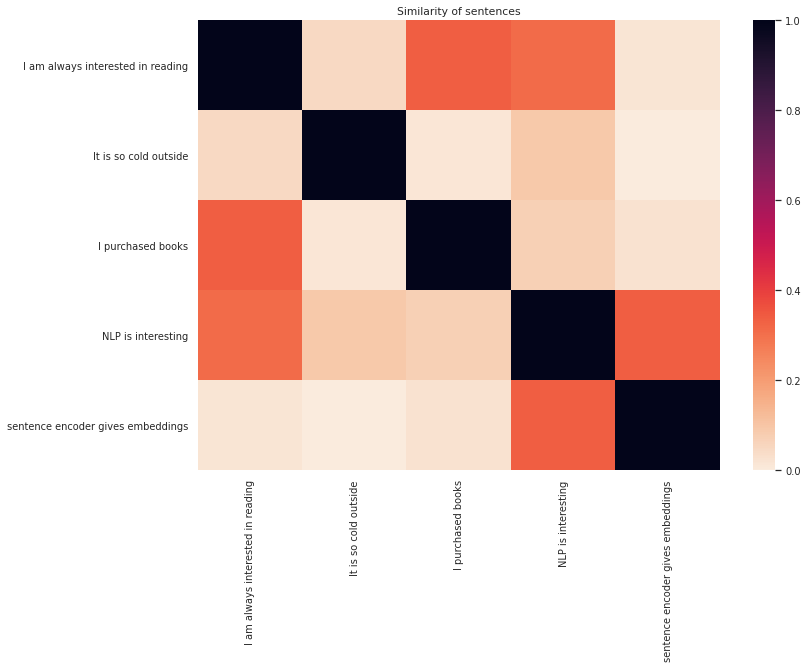

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the similarity between sentences by using the embeddings generated from USE 
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features).reshape(len(labels),len(labels))
  sns.set(font_scale=0.9,rc={'figure.figsize':(11.7,8.27)})
  g = sns.heatmap(corr,xticklabels=labels,yticklabels=labels,vmin=0,vmax=1,cmap="rocket_r")
  g.figsize=(10,5)
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Similarity of sentences")


def run_and_plot(sentences,embeddings):
  plot_similarity(sentences, embeddings, 90)

run_and_plot(sample_sentences,sample_sentence_embedding)